### 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Apply the default Seaborn theme
sns.set_theme()

### 2. Load Data


In [3]:
# Load the dataset
df = pd.read_csv("../dataset/data.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [4]:
# Load the variables table
df_variables = pd.read_csv("../dataset/variables.csv")
df_variables.head(len(df_variables))

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,NaN,NaN,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",NaN,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",NaN,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",NaN,no
4,default,Feature,Binary,NaN,has credit in default?,NaN,no
5,balance,Feature,Integer,NaN,average yearly balance,euros,no
6,housing,Feature,Binary,NaN,has housing loan?,NaN,no
7,loan,Feature,Binary,NaN,has personal loan?,NaN,no
8,contact,Feature,Categorical,NaN,contact communication type (categorical: 'cell...,NaN,yes
9,day_of_week,Feature,Date,NaN,last contact day of the week,NaN,no


In [5]:
# Check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


#### 2.1. Target Variable


In [6]:
# Target variable
df_target = pd.read_csv("../dataset/labels.csv")
df_target.head()

,y
0,no
1,no
2,no
3,no
4,no


In [7]:
# Value counts
df_target["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [8]:
# Normalised value counts
df_target["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

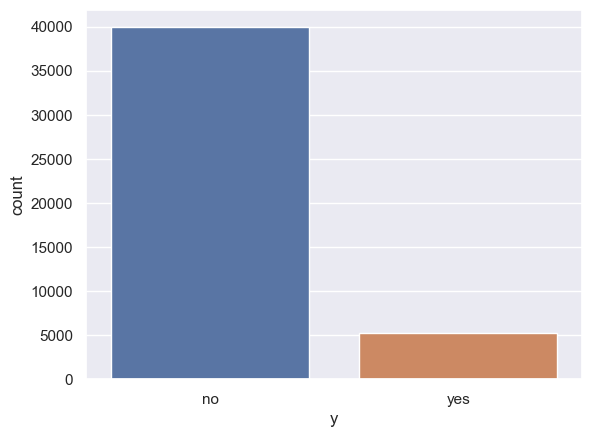

In [9]:
# Visualise the target variable
sns.countplot(x="y", data=df_target, hue="y")
plt.show()

In [10]:
# Add the 'y' column from df_target as a new column in df
df["y"] = df_target["y"]
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


### 3. Exploratory Data Analysis


#### 3.1. Missing Values


In [11]:
# Count missing values per column
df.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

In [12]:
# Replace missing values

# Numerical columns have no missing values

# Categorical columns
df = df.fillna(value={"job": "missing"})
df = df.fillna(value={"education": "missing"})
df = df.fillna(value={"contact": "missing"})
df = df.fillna(value={"poutcome": "missing"})

In [13]:
# Recount missing values per column
df.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

#### 3.2. Unique Values


In [14]:
# Investigate unique values
df.nunique()

age              77
job              12
marital           3
education         4
default           2
balance        7168
housing           2
loan              2
contact           3
day_of_week      31
month            12
duration       1573
campaign         48
pdays           559
previous         41
poutcome          4
y                 2
dtype: int64

#### 3.3. Categorical Variables


In [15]:
# Categorical Variables
def explore_categorical(col_name):
    print("{0} Summary".format(col_name))
    print("\n")

    # Print the count of each category
    print("{0} Counts".format(col_name))
    print(df[col_name].value_counts())
    print("\n")

    # Print the ratio of each category
    print("{0} Ratio".format(col_name))
    print(df[col_name].value_counts(normalize=True))
    print("\n")

    # Print counts of y grouped by the categorical column
    print("{0} Default Counts".format(col_name))
    print(df.groupby(col_name)["y"].value_counts().unstack(level=-1))
    print("\n")

    # Print ratio of y grouped by the categorical column
    print("{0} Default Ratio".format(col_name))
    print(df.groupby(col_name)["y"].value_counts(normalize=True).unstack(level=-1))
    print("\n")

    # Plot ratio of y by the categorical column
    sns.catplot(data=df, kind="count", x=col_name, hue="y")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

job Summary


job Counts
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
missing           288
Name: count, dtype: int64


job Ratio
job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
missing          0.006370
Name: proportion, dtype: float64


job Default Counts
y                no   yes
job                      
admin.         4540   631
blue-collar    9024   708
entrepreneur   1364   123
housemaid      1131   109
management     8157  1301
missing         254    34
retired        1748   516
self-employed  1392   187
services       3785   369
student      

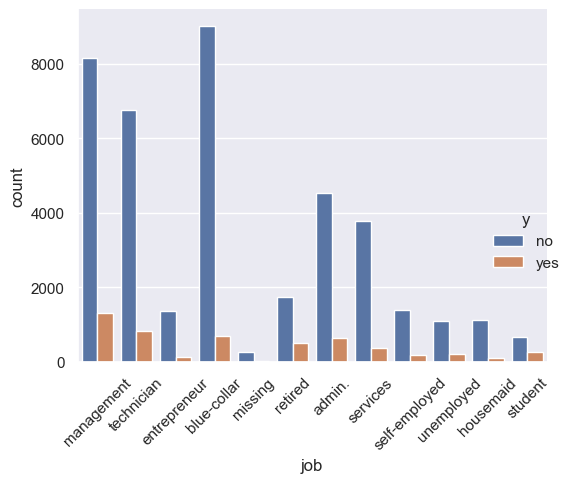

In [16]:
# Explore job column
explore_categorical("job")

#### 3.4. Continuous Variables


In [17]:
# Continous Variables
def explore_continuous(col_name):
    # Print statistical summary
    print("{0} Summary".format(col_name))
    print("\n")
    print(df[col_name].describe())
    print("\n")

    # Look at boxplot
    sns.boxplot(x=col_name, data=df)
    plt.show()

    # Look at the distribution
    sns.displot(df[col_name], kde=True)
    plt.show()

    # Grouping with the target variable
    print("{0} Grouped Summary".format(col_name))
    print("\n")
    print(df.groupby("y")[col_name].describe())

    # Look at grouped boxplot
    sns.boxplot(x=col_name, y="y", data=df, orient="h")
    plt.show()

age Summary


count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64




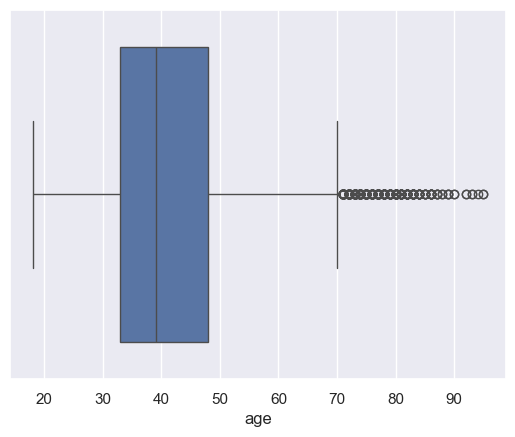

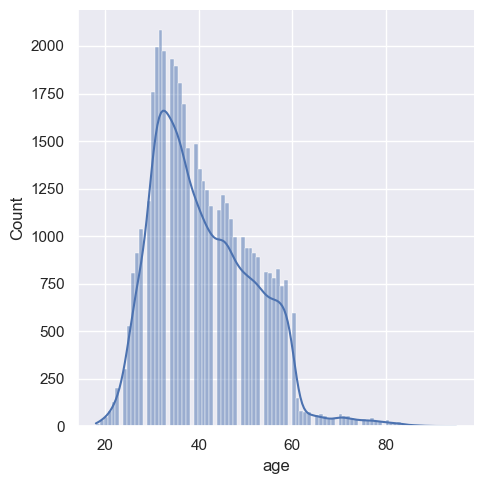

age Grouped Summary


       count       mean        std   min   25%   50%   75%   max
y                                                               
no   39922.0  40.838986  10.172662  18.0  33.0  39.0  48.0  95.0
yes   5289.0  41.670070  13.497781  18.0  31.0  38.0  50.0  95.0


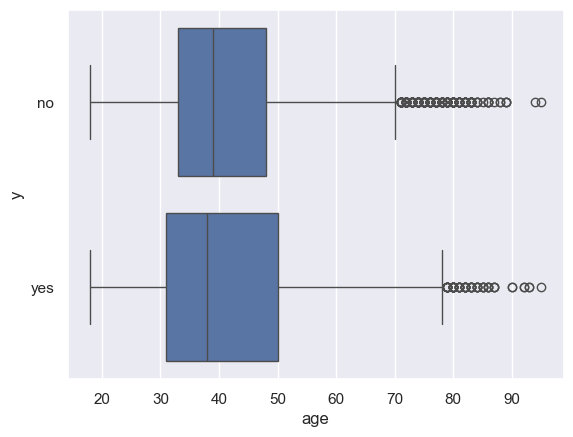

In [18]:
# Explore age column
explore_continuous('age')

#### 3.5. Binary Variables


housing Summary


housing Counts
housing
yes    25130
no     20081
Name: count, dtype: int64


housing Ratio
housing
yes    0.555838
no     0.444162
Name: proportion, dtype: float64


housing Default Counts
y           no   yes
housing             
no       16727  3354
yes      23195  1935


housing Default Ratio
y              no       yes
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000




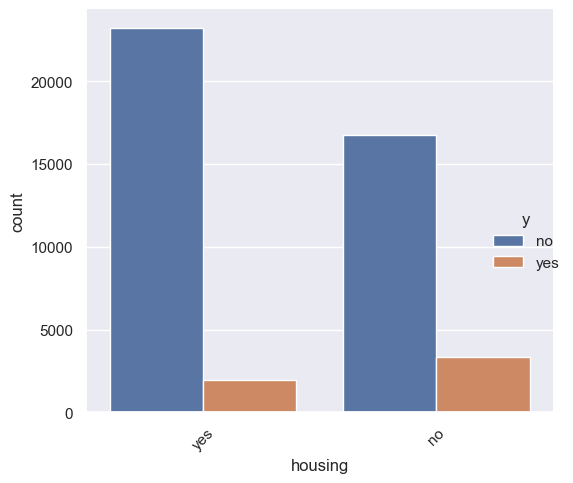

In [19]:
# Binary Variables
explore_categorical("housing")

### 4. Feature Engineering


#### 4.1. Normalisation


##### 4.1.1. Numerical Columns


In [20]:
numerical_columns = df_variables[df_variables["type"] == "Integer"]["name"].tolist()
print(numerical_columns)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


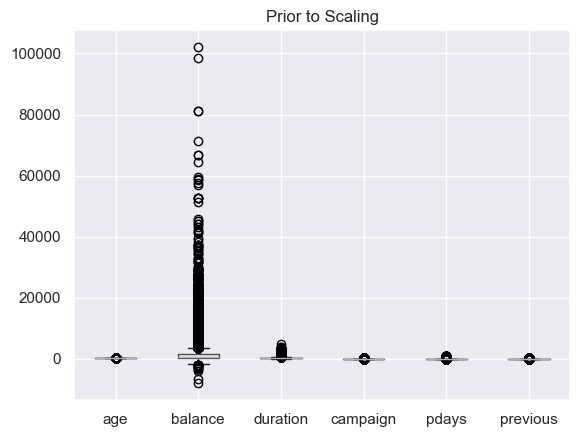

In [21]:
# Prior to scaling
df[numerical_columns].boxplot()
plt.title("Prior to Scaling")
plt.show()

In [22]:
# Min-max normalisation
mm_scalar = MinMaxScaler()
df[numerical_columns] = mm_scalar.fit_transform(df[numerical_columns])

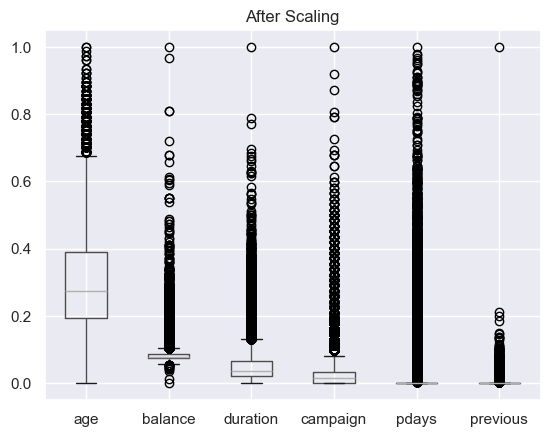

In [23]:
# After scaling
df[numerical_columns].boxplot()
plt.title("After Scaling")
plt.show()

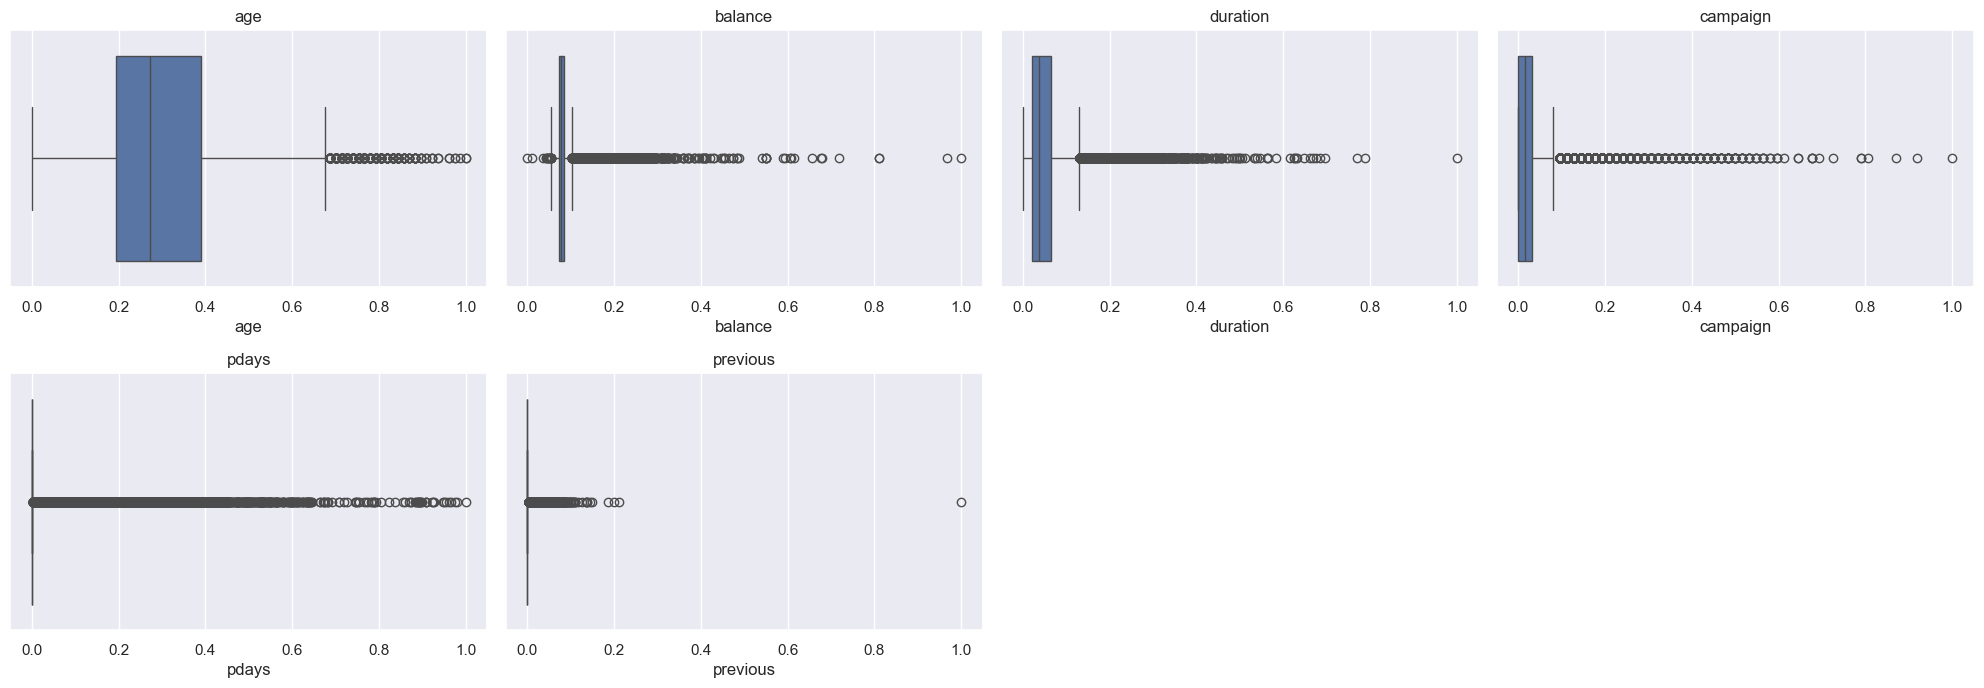

In [24]:
# Create a box plot to visualise outliers
plt.figure(figsize=(20, 10))
for i in range(len(numerical_columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x=df[numerical_columns[i]])
    plt.title(numerical_columns[i])
plt.tight_layout()
plt.show()

###### Outliers

RobustScaler is a good alternative when dealing with data that contains many outliers. 

In [25]:
# # Robust normalisation
# rb_scalar = RobustScaler()
# df[numerical_columns] = rb_scalar.fit_transform(df[numerical_columns])

# # After scaling
# df[numerical_columns].boxplot()
# plt.title("After Scaling")
# plt.show()

##### 4.1.2. Binary Columns


In [26]:
binary_columns = df_variables[df_variables["type"] == "Binary"]["name"].tolist()
print(binary_columns)

['default', 'housing', 'loan', 'y']


In [27]:
df[binary_columns] = df[binary_columns].apply(lambda col: col.map({"yes": 1, "no": 0}))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,management,married,tertiary,0,0.092259,1,0,missing,5,may,0.053070,0.0,0.0,0.0,missing,0
1,0.337662,technician,single,secondary,0,0.073067,1,0,missing,5,may,0.030704,0.0,0.0,0.0,missing,0
2,0.194805,entrepreneur,married,secondary,0,0.072822,1,1,missing,5,may,0.015453,0.0,0.0,0.0,missing,0
3,0.376623,blue-collar,married,missing,0,0.086476,1,0,missing,5,may,0.018707,0.0,0.0,0.0,missing,0
4,0.194805,missing,single,missing,0,0.072812,0,0,missing,5,may,0.040260,0.0,0.0,0.0,missing,0


##### 4.1.3. Categorical Columns


###### Ordinal Columns


In [28]:
ordinal_column = "education"
categories = sorted(df[ordinal_column].unique())

In [29]:
# Ordinal-encoding
df[ordinal_column] = df[ordinal_column].apply(
    lambda x: (categories.index(x)) / (len(categories) - 1)
)

print(df[ordinal_column].value_counts())

education
0.666667    23202
1.000000    13301
0.333333     6851
0.000000     1857
Name: count, dtype: int64


###### Nominal Columns


In [30]:
nominal_column = df_variables[
    (df_variables["type"] == "Categorical") & (df_variables["name"] != "education")
]["name"].tolist()
print(nominal_column)

['job', 'marital', 'contact', 'poutcome']


In [31]:
# One-hot encoding
df = pd.get_dummies(df, columns=nominal_column, drop_first=False)
new_cols = [
    col
    for col in df.columns
    if any(orig_col + "_" in col for orig_col in nominal_column)
]
df[new_cols] = df[new_cols].astype(int)

df.head()

,age,education,default,balance,housing,loan,day_of_week,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,may,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,may,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,may,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,may,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,may,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


##### 4.1.4. Date Columns


In [32]:
# explore_categorical('day')

# Rename 'day_of_week' to 'day'
df.rename(columns={"day_of_week": "day"}, inplace=True)
df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,may,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,may,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,may,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,may,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,may,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


In [33]:
# explore_categorical('month')

# Convert month names to month numbers
month_map = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
    "sep": 9,
    "oct": 10,
    "nov": 11,
    "dec": 12,
}
df["month"] = df["month"].map(month_map)

df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success
0,0.519481,1.000000,0,0.092259,1,0,5,5,0.053070,0.0,...,0,1,0,0,1,0,0,1,0,0
1,0.337662,0.666667,0,0.073067,1,0,5,5,0.030704,0.0,...,0,0,1,0,1,0,0,1,0,0
2,0.194805,0.666667,0,0.072822,1,1,5,5,0.015453,0.0,...,0,1,0,0,1,0,0,1,0,0
3,0.376623,0.000000,0,0.086476,1,0,5,5,0.018707,0.0,...,0,1,0,0,1,0,0,1,0,0
4,0.194805,0.000000,0,0.072812,0,0,5,5,0.040260,0.0,...,0,0,1,0,1,0,0,1,0,0


In [34]:
# Cyclical encoding for day of the month (assuming max 31 days)
df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)

# Cyclical encoding for month (12 months in a year)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success,day_sin,day_cos,month_sin,month_cos
0,0.519481,1.000000,0,0.092259,1,0,5,5,0.053070,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
1,0.337662,0.666667,0,0.073067,1,0,5,5,0.030704,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
2,0.194805,0.666667,0,0.072822,1,1,5,5,0.015453,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
3,0.376623,0.000000,0,0.086476,1,0,5,5,0.018707,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
4,0.194805,0.000000,0,0.072812,0,0,5,5,0.040260,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025


In [35]:
# Drop the original 'month' and 'day_of_week' columns
df.drop(columns=["month", "day"], inplace=True)

df.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success,day_sin,day_cos,month_sin,month_cos
0,0.519481,1.000000,0,0.092259,1,0,0.053070,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
1,0.337662,0.666667,0,0.073067,1,0,0.030704,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
2,0.194805,0.666667,0,0.072822,1,1,0.015453,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
3,0.376623,0.000000,0,0.086476,1,0,0.018707,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
4,0.194805,0.000000,0,0.072812,0,0,0.040260,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025


### Train/Test Split


In [36]:
# Drop the target variable from the features
X = df.drop(['y'], axis=1)
y = df['y']

# Drop the duration variable from the features
# X = df.drop(['duration'], axis=1)

X.head()

,age,education,default,balance,housing,loan,duration,campaign,pdays,previous,...,contact_missing,contact_telephone,poutcome_failure,poutcome_missing,poutcome_other,poutcome_success,day_sin,day_cos,month_sin,month_cos
0,0.519481,1.000000,0,0.092259,1,0,0.053070,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
1,0.337662,0.666667,0,0.073067,1,0,0.030704,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
2,0.194805,0.666667,0,0.072822,1,1,0.015453,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
3,0.376623,0.000000,0,0.086476,1,0,0.018707,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025
4,0.194805,0.000000,0,0.072812,0,0,0.040260,0.0,0.0,0.0,...,1,0,0,1,0,0,0.848644,0.528964,0.5,-0.866025


In [37]:
# Check dimensions of features and target
print(X.shape)
print(y.shape)

(45211, 36)
(45211,)


In [38]:
# Check info and dtype of features and targets
X.info()
y.dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  float64
 1   education          45211 non-null  float64
 2   default            45211 non-null  int64  
 3   balance            45211 non-null  float64
 4   housing            45211 non-null  int64  
 5   loan               45211 non-null  int64  
 6   duration           45211 non-null  float64
 7   campaign           45211 non-null  float64
 8   pdays              45211 non-null  float64
 9   previous           45211 non-null  float64
 10  job_admin.         45211 non-null  int64  
 11  job_blue-collar    45211 non-null  int64  
 12  job_entrepreneur   45211 non-null  int64  
 13  job_housemaid      45211 non-null  int64  
 14  job_management     45211 non-null  int64  
 15  job_missing        45211 non-null  int64  
 16  job_retired        452

dtype('int64')

In [39]:
# Convert to numpy arrays
X = X.values
y = y.values
X.dtype, y.dtype

(dtype('float64'), dtype('int64'))

In [40]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Neural Network


In [41]:
# Create a Neural Network class that inherits from nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 36)
        self.fc2 = nn.Linear(36, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [42]:
# Set random seed for reproducibility
# torch.manual_seed(42)

In [43]:
# Create an instance of the NeuralNetwork class
model = NeuralNetwork(input_size=X_train.shape[1])

# Print the model architecture
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=36, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)


In [44]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Print the shape of the tensors
print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)


torch.Size([36168, 36])
torch.Size([36168])
torch.Size([9043, 36])
torch.Size([9043])


In [45]:
# Optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # Try decaying lr 

# Count class frequencies
class_counts = np.bincount(y_train)
total = class_counts.sum()

# Compute weights inversely proportional to class frequency; 2.0 for binary classes
weights = total / (2.0 * class_counts)  

# Convert to PyTorch tensor
class_weights = torch.tensor(weights, dtype=torch.float32)

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Number of epochs
num_epochs = 500
losses = []

# Training loop
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.6866
Epoch [20/500], Loss: 0.6732
Epoch [30/500], Loss: 0.6533
Epoch [40/500], Loss: 0.6275
Epoch [50/500], Loss: 0.6028
Epoch [60/500], Loss: 0.5857
Epoch [70/500], Loss: 0.5699
Epoch [80/500], Loss: 0.5542
Epoch [90/500], Loss: 0.5346
Epoch [100/500], Loss: 0.5088
Epoch [110/500], Loss: 0.4774
Epoch [120/500], Loss: 0.4452
Epoch [130/500], Loss: 0.4180
Epoch [140/500], Loss: 0.3952
Epoch [150/500], Loss: 0.3765
Epoch [160/500], Loss: 0.3624
Epoch [170/500], Loss: 0.3523
Epoch [180/500], Loss: 0.3444
Epoch [190/500], Loss: 0.3387
Epoch [200/500], Loss: 0.3344
Epoch [210/500], Loss: 0.3310
Epoch [220/500], Loss: 0.3285
Epoch [230/500], Loss: 0.3255
Epoch [240/500], Loss: 0.3232
Epoch [250/500], Loss: 0.3212
Epoch [260/500], Loss: 0.3191
Epoch [270/500], Loss: 0.3174
Epoch [280/500], Loss: 0.3157
Epoch [290/500], Loss: 0.3142
Epoch [300/500], Loss: 0.3129
Epoch [310/500], Loss: 0.3117
Epoch [320/500], Loss: 0.3106
Epoch [330/500], Loss: 0.3096
Epoch [340/500], Lo

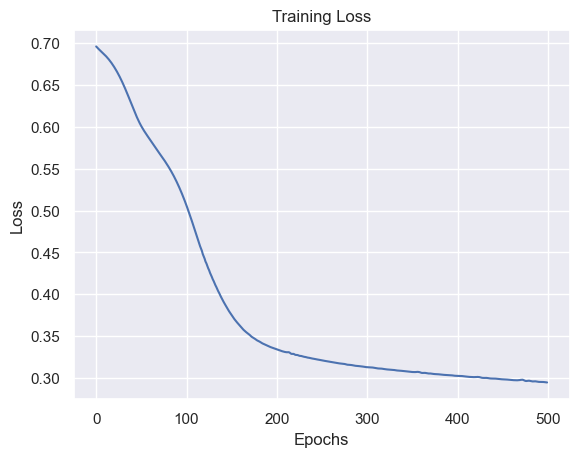

In [46]:
# Plot the training loss
plt.plot(range(num_epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Model Evaluation


Accuracy: 0.8298
Confusion Matrix:
[[6549 1403]
 [ 136  955]]


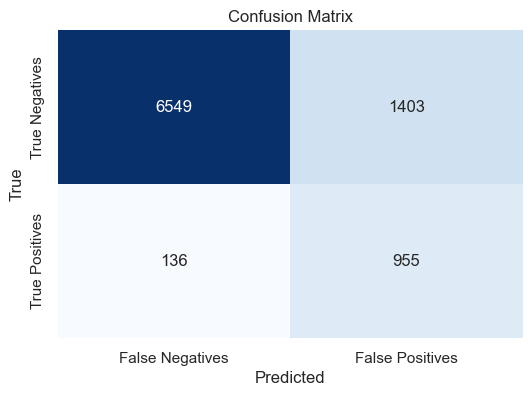

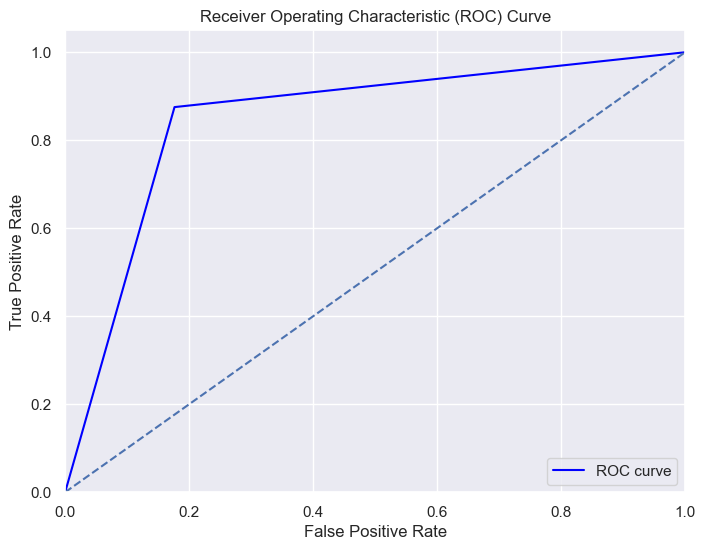

AUC: 0.8495
Precision: 0.4050
Recall: 0.8753
F1 Score: 0.5538


In [47]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    # Forward pass
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)

    # Convert predictions to numpy array
    predicted = predicted.numpy()
    y_test = y_test_tensor.numpy()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted)
    print(f'Accuracy: {accuracy:.4f}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted)
# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a DataFrame for easier plotting
conf_mat_df = pd.DataFrame(cm, 
                          index=['True Negatives', 'True Positives'],
                          columns=['False Negatives', 'False Positives'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate AUC
roc_auc = auc(fpr, tpr)
# Print AUC
print(f'AUC: {roc_auc:.4f}')

# Calculate precision
precision = precision_score(y_test, predicted, zero_division=0)
# Print precision
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, predicted, zero_division=0)
# Print recall
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, predicted, zero_division=0)
# Print F1 score
print(f'F1 Score: {f1:.4f}')


Imbalanced Dataset

* The model has a heavy imbalance, 88% class 0, 12%, class 1. The model learns to predict only the majority class - leading to high accurary, but 0 precision/recall/F1.
* Applied class balancing, see below. 

In [48]:
# # Count class frequencies
# class_counts = np.bincount(y_train)
# total = class_counts.sum()

# # Compute weights inversely proportional to class frequency; 2.0 for binary classes
# weights = total / (2.0 * class_counts)  

# # Convert to PyTorch tensor
# class_weights = torch.tensor(weights, dtype=torch.float32)

# # Loss function
# criterion = nn.CrossEntropyLoss(weight=class_weights)

### Overfitting
#### Regularisation
* Applied L2 Regularisation (Weight Decay)

In [49]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)